# Space influenza  

A toy-model binary classification task taken from [Martin 2018](https://www.packtpub.com/product/bayesian-analysis-with-python-second-edition/9781789341652) and [Martin et al. 2021](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368).

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pymc_bart as pmb

In [2]:
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

## Data generation

In [3]:
sin = np.loadtxt("space_influenza.csv", skiprows=1, delimiter=",")

X = sin[:, 1][:, None]
Y = sin[:, 2]
Y_jittered = np.random.normal(Y, 0.02)

In [4]:
idatas = {}
ms = ["10", "20", "50", "100", "200"]

for m in ms:
    with pm.Model() as model:
        μ = pmb.BART("μ", X, Y, m=int(m))
        p = pm.Deterministic("p", pm.math.sigmoid(μ))
        y = pm.Bernoulli("y", p=p, observed=Y)
        idata = pm.sample()

    idatas[m] = idata

Multiprocess sampling (3 chains in 3 jobs)
PGBART: [μ]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 11 seconds.
Multiprocess sampling (3 chains in 3 jobs)
PGBART: [μ]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 20 seconds.
Multiprocess sampling (3 chains in 3 jobs)
PGBART: [μ]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 45 seconds.
Multiprocess sampling (3 chains in 3 jobs)
PGBART: [μ]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 87 seconds.
Multiprocess sampling (3 chains in 3 jobs)
PGBART: [μ]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 171 seconds.


/home/pablo/Programas/arviz/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/pablo/Programas/arviz/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/pablo/Programas/arviz/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/pablo/Programas/arviz/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently int

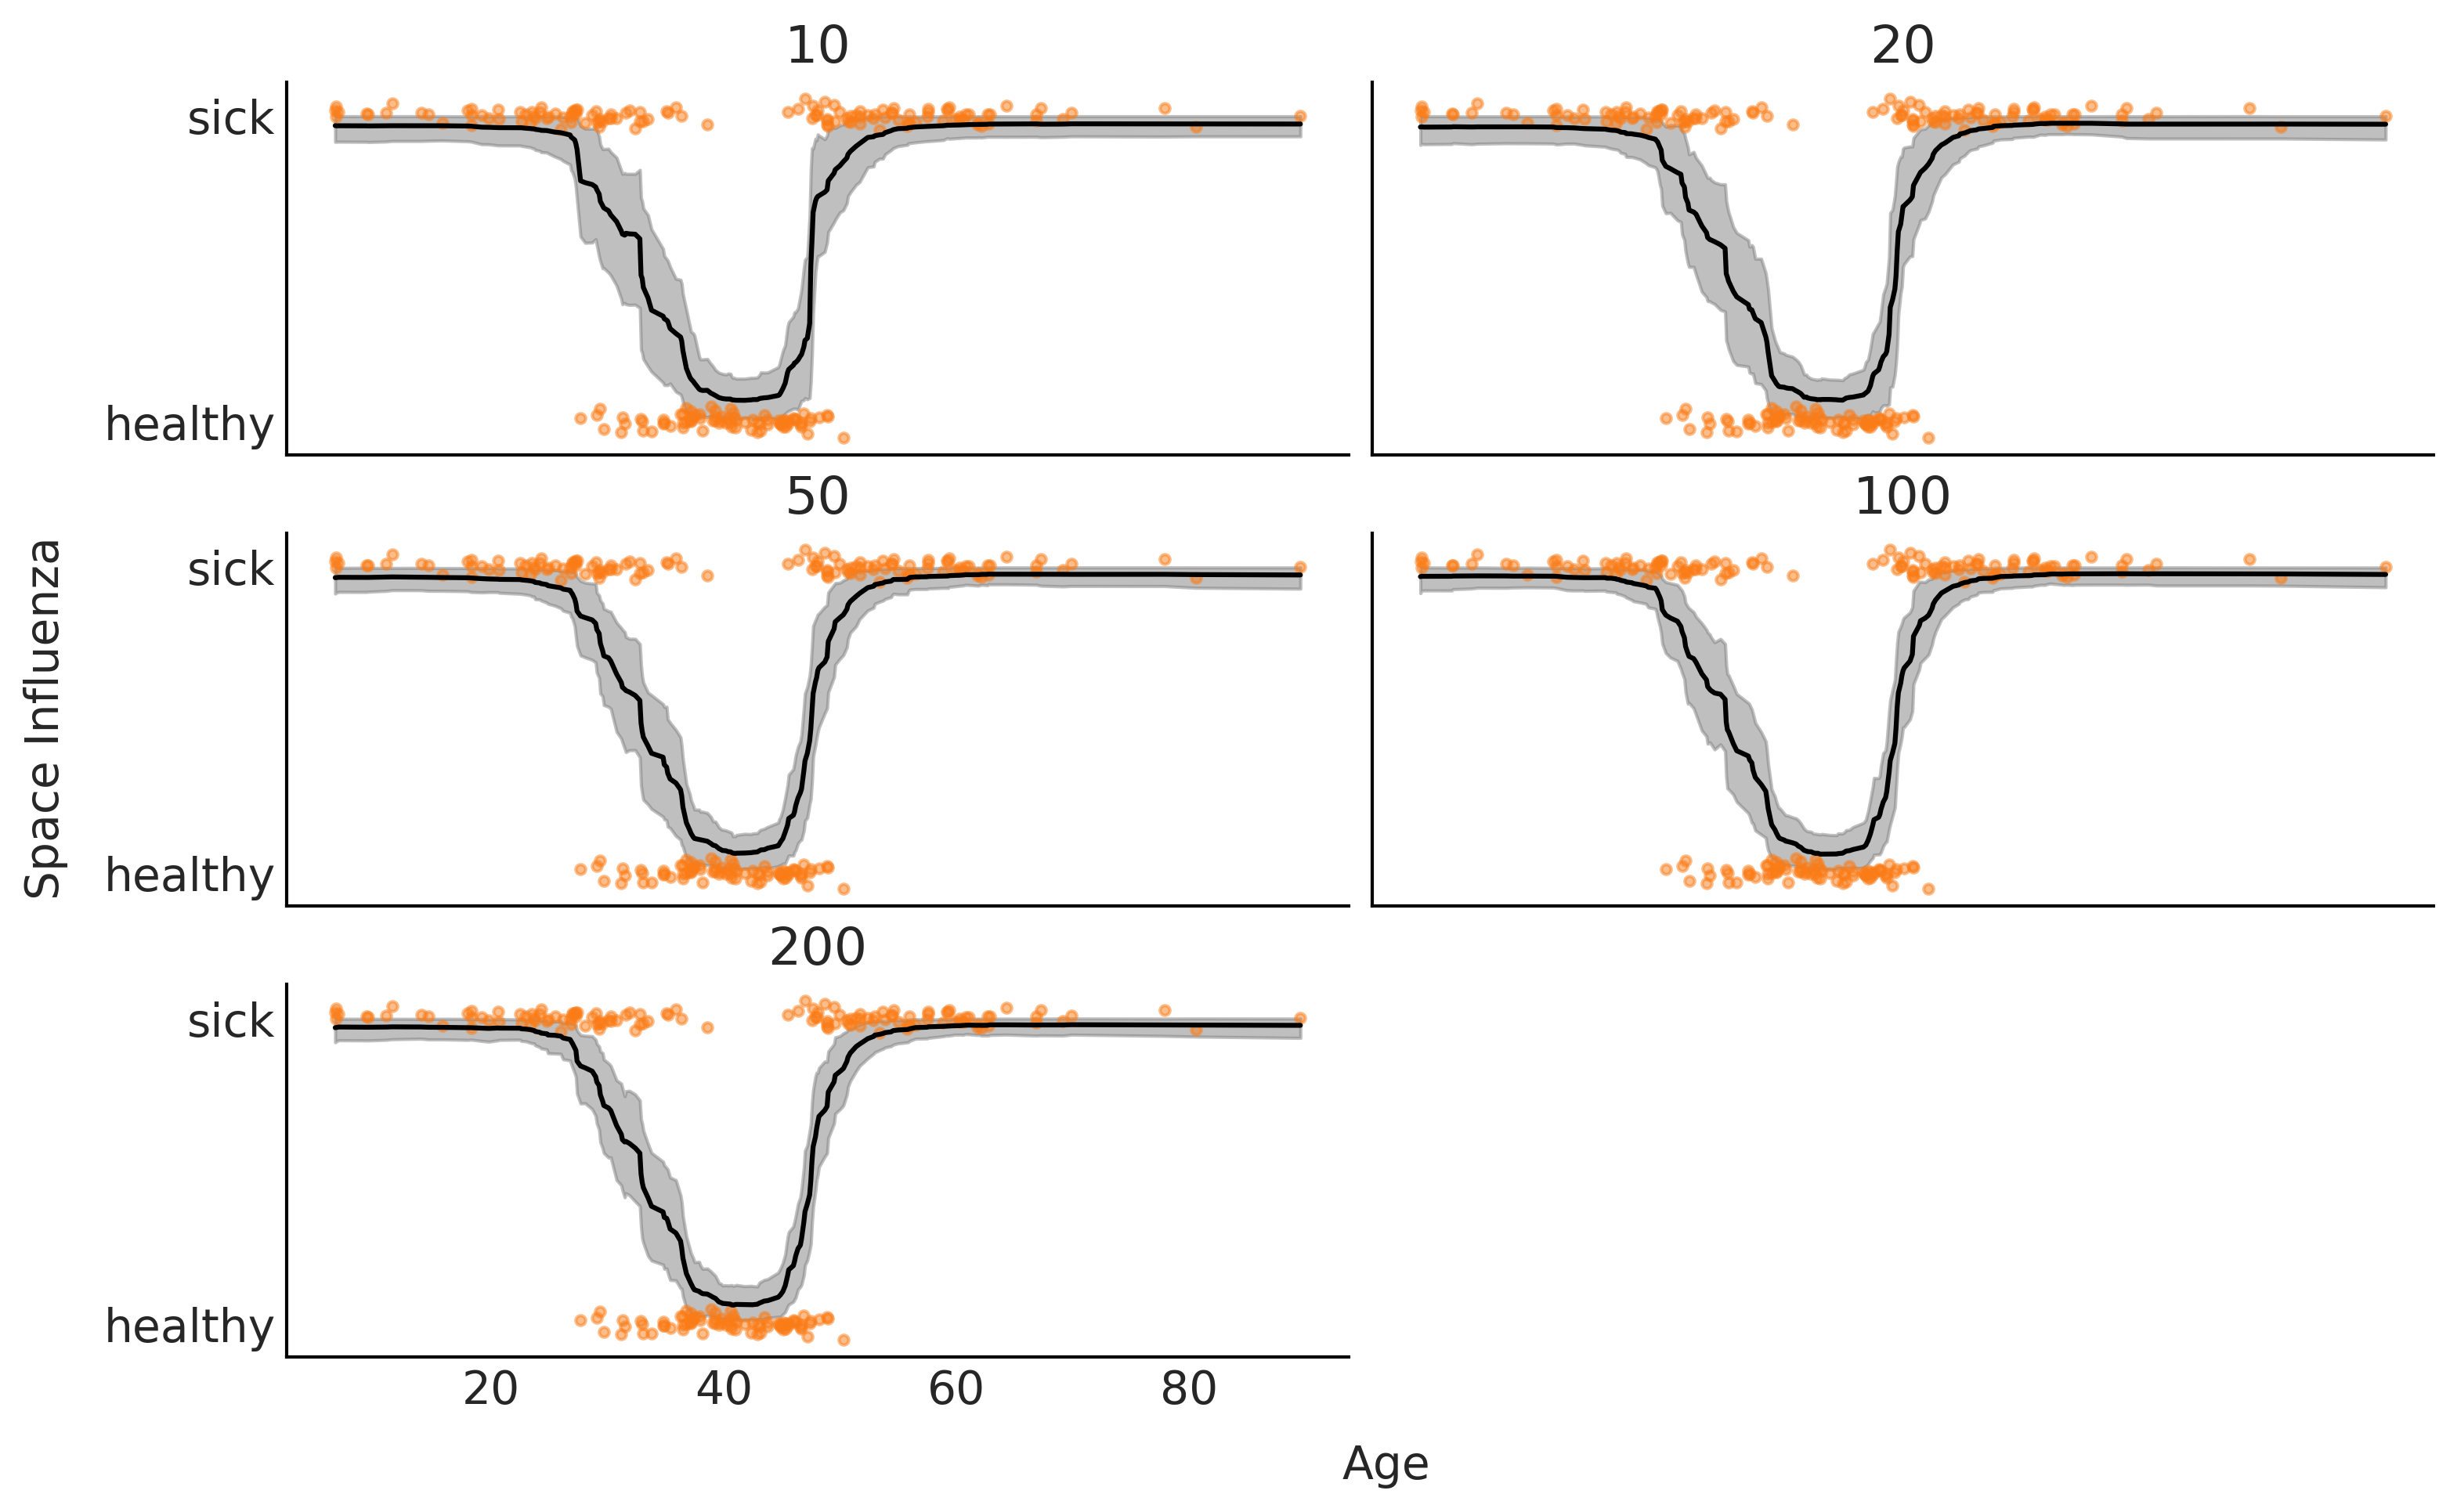

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(10, 6), sharey=True, sharex=True)

for ax, (m, idata) in zip(np.ravel(axes), idatas.items()):
    ps = idata.posterior["p"].stack({"draws": ["chain", "draw"]})

    ax.plot(X, Y_jittered, "C1.", alpha=0.5)

    X_idx = np.argsort(X[:, 0])
    ax.plot(X[:, 0][X_idx], np.mean(ps, 1)[X_idx], "k-")

    az.plot_hdi(X[:, 0], ps.T, ax=ax, smooth=False, color="0.5")
    ax.set_title(m)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["healthy", "sick"])
axes[2, 1].remove()
fig.text(0.55, -0.04, "Age", ha="center", size=14)
fig.text(-0.03, 0.5, "Space Influenza", va="center", size=14, rotation=90);

In [6]:
cmp = az.compare(idatas)
cmp

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
200,0,-59.767918,3.446548,0.000000,1.0,6.285822,0.000000,False,log
100,1,-60.228226,3.921486,0.460308,0.0,6.381934,0.236106,False,log
50,2,-61.025942,4.185164,1.258023,0.0,6.358583,0.170915,False,log
20,3,-62.289692,5.962660,2.521774,0.0,6.569620,0.556653,False,log
10,4,-62.665263,6.875226,2.897345,0.0,6.767521,1.014630,False,log


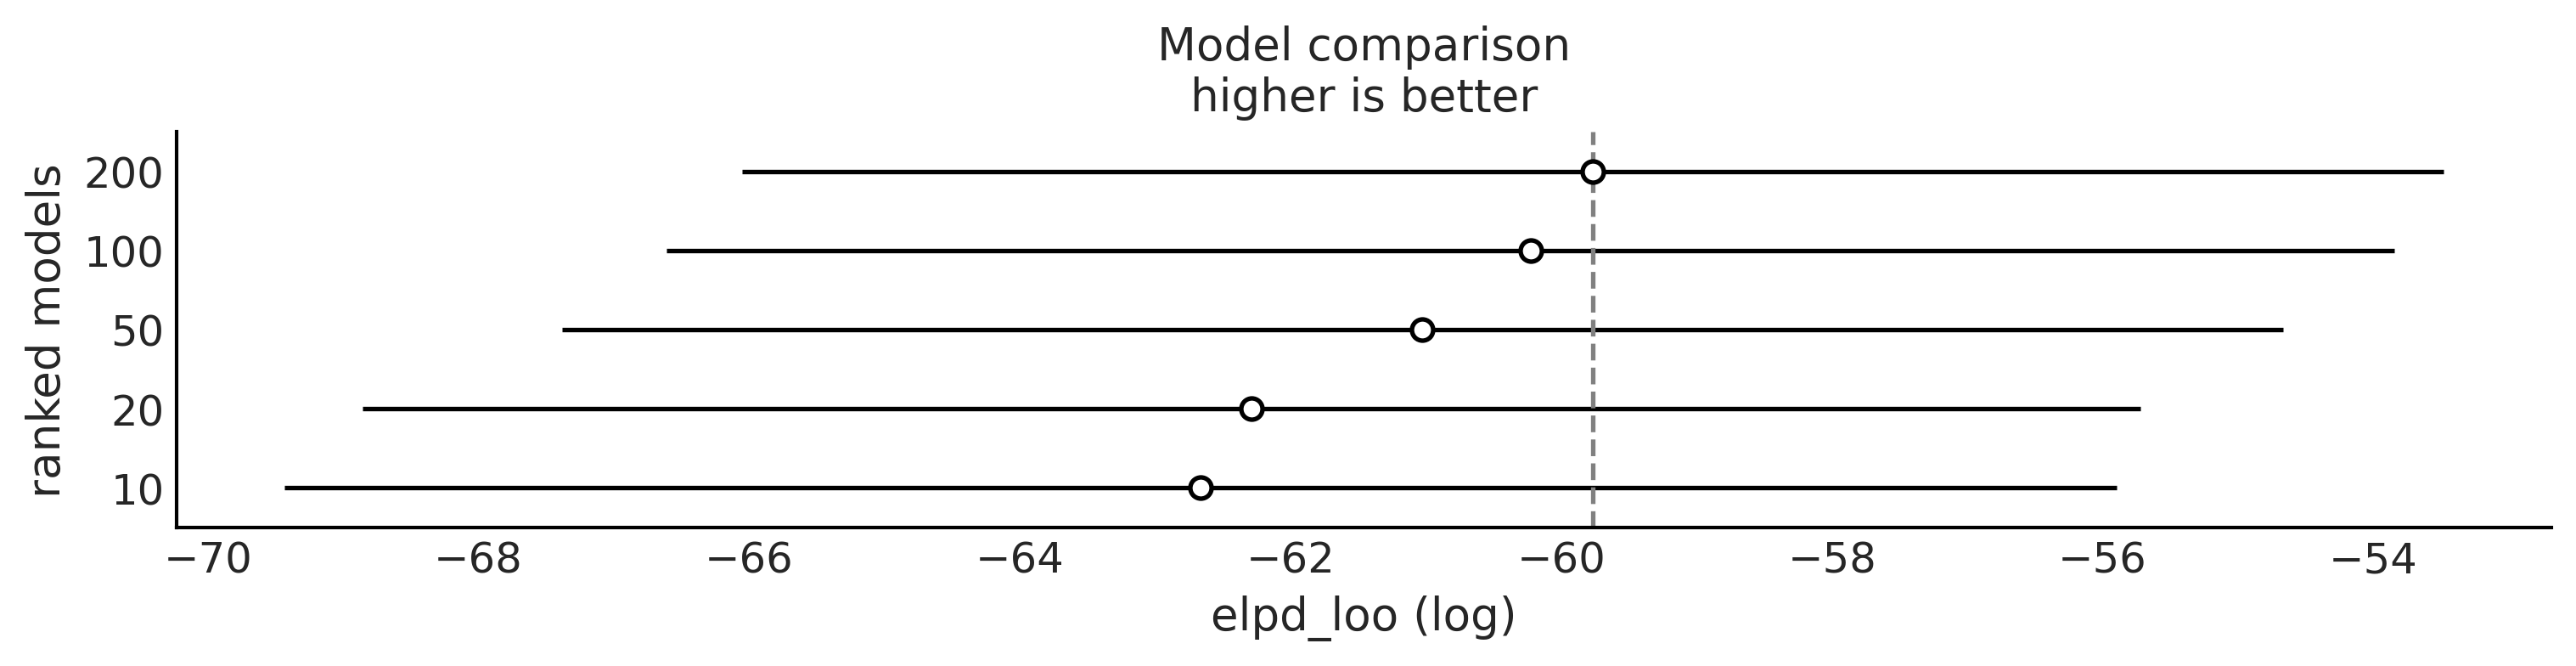

In [7]:
az.plot_compare(
    cmp, plot_ic_diff=False, insample_dev=False, figsize=(10, 2.5), legend=False
);